In [ ]:
# Utility imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import tensorflow as tf
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import random
from keras.regularizers import l2
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error

# Machine learning imports
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from tensorflow import keras
from tensorflow.keras import layers, optimizers, preprocessing
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
df = pd.read_excel("FOREXPY7.xlsx")

In [ ]:
print(df)

            Date  12-Month Inflation  Interest Rate Lending  Trade Balance  \
0     12/09/2004                4.70                  16.71       -6373.83   
1     12/09/2004                4.40                  16.42       -8449.28   
2     02/11/2004                3.72                  17.26       -4730.77   
3     03/11/2004                4.27                  17.78       -7286.46   
4     04/11/2004                6.87                  17.94       -7087.95   
...          ...                 ...                    ...            ...   
4896  08/04/2024                7.56                  17.80      -57289.67   
4897  09/04/2024                7.56                  17.80      -57289.67   
4898  11/04/2024                7.56                  17.80      -57289.67   
4899  12/04/2024                7.56                  17.80      -57289.67   
4900  15/04/2024                7.56                  17.80      -57289.67   

            GDP  MeanFOREX  
0      0.791265    84.3208  
1    

#EDA

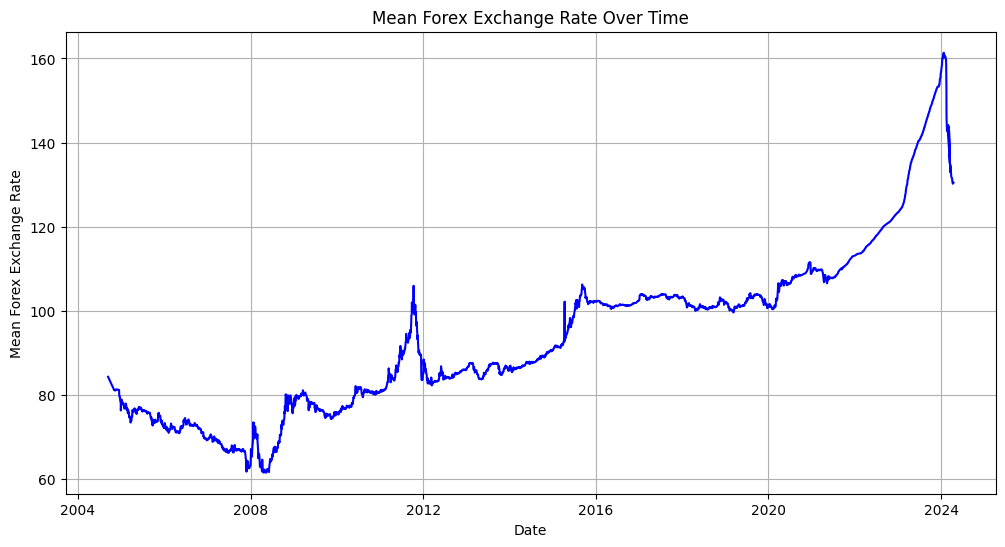

In [ ]:
eda_df=df
eda_df['Date'] = pd.to_datetime(eda_df['Date'], format='%d/%m/%Y')

eda_df['Date'] = pd.to_datetime(eda_df['Date'])

eda_df.set_index('Date', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(eda_df.index, eda_df['MeanFOREX'], color='blue')
plt.title('Mean Forex Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Mean Forex Exchange Rate')
plt.grid(True)
plt.show()

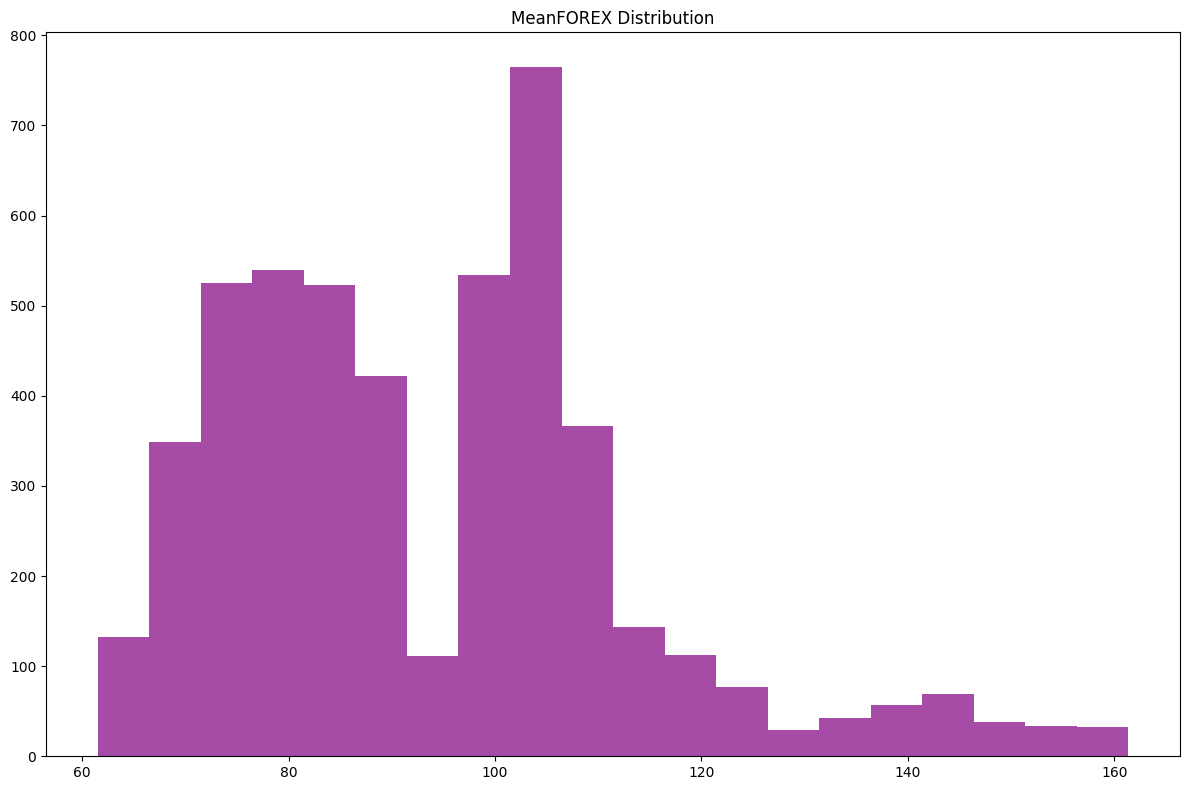

In [ ]:

plt.figure(figsize=(12, 8))
plt.hist(df['MeanFOREX'], bins=20, color='purple', alpha=0.7)
plt.title('MeanFOREX Distribution')

plt.tight_layout()
plt.show()


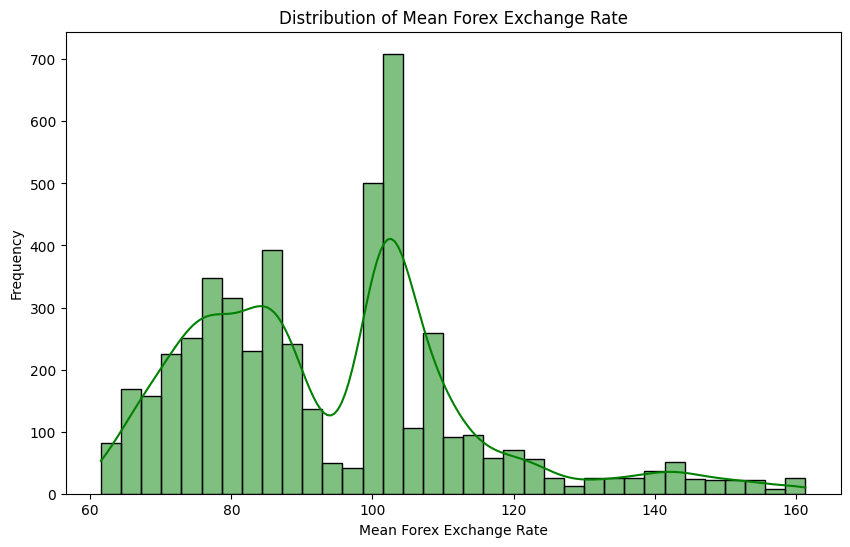

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['MeanFOREX'], kde=True, color='green')
plt.title('Distribution of Mean Forex Exchange Rate')
plt.xlabel('Mean Forex Exchange Rate')
plt.ylabel('Frequency')
plt.show()

In [ ]:
print(df)

            12-Month Inflation  Interest Rate Lending  Trade Balance  \
Date                                                                   
2004-09-12                4.70                  16.71       -6373.83   
2004-09-12                4.40                  16.42       -8449.28   
2004-11-02                3.72                  17.26       -4730.77   
2004-11-03                4.27                  17.78       -7286.46   
2004-11-04                6.87                  17.94       -7087.95   
...                        ...                    ...            ...   
2024-04-08                7.56                  17.80      -57289.67   
2024-04-09                7.56                  17.80      -57289.67   
2024-04-11                7.56                  17.80      -57289.67   
2024-04-12                7.56                  17.80      -57289.67   
2024-04-15                7.56                  17.80      -57289.67   

                  GDP  MeanFOREX  
Date                        

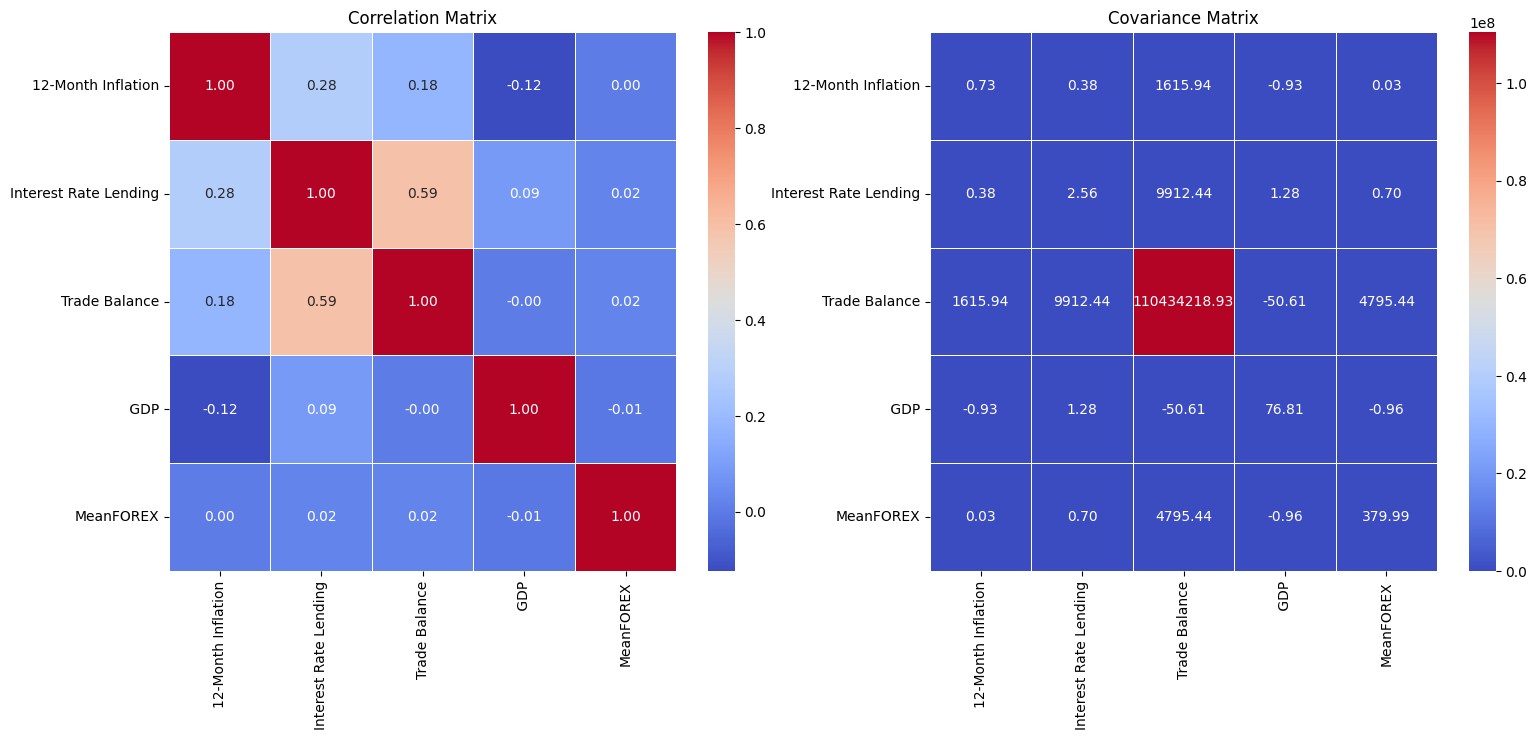

In [ ]:
correlation_matrix = df.corr()
covariance_matrix = df.cov()

plt.figure(figsize=(18, 7))

plt.subplot(1, 2, 1)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(covariance_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Covariance Matrix')

plt.show()

#Split and Scale data

In [ ]:
n_past = 7

def create_dataset(data, n_past):
    X, y = [], []
    for i in range(n_past, len(data)):
        X.append(data.iloc[i-n_past:i,:].values)
        y.append(data.iloc[i, -1])
    return np.array(X), np.array(y)

X, y = create_dataset(df, n_past)
print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")

Shape of X: (4894, 7, 5), Shape of y: (4894,)


In [ ]:
# Scale X
scaler_X = MinMaxScaler()
n_samples, n_time_steps, n_features = X.shape
X = X.reshape(n_samples * n_time_steps, n_features)
X_scaled = scaler_X.fit_transform(X)
X_scaled = X_scaled.reshape(n_samples, n_time_steps, n_features)

# Scale y
scaler_y = MinMaxScaler()
y = y.reshape(-1, 1)
y_scaled = scaler_y.fit_transform(y)
y_scaled = y_scaled.ravel()



In [ ]:
X_scaled.shape, y_scaled.shape

((4894, 7, 5), (4894,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)


#LSTM

In [ ]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
sequence_length = n_past
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, n_features)))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.4))

model.add(Dense(1))

optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), verbose=1)

model.save("lstm_model.h5")

model.summary()

loss, mae = model.evaluate(X_test, y_test, verbose=0)

print(f'Mean Squared Error on Test Set: {loss}')
print(f'Mean Absolute Error on Test Set: {mae}')

Epoch 1/100
123/123 [==============================] - 4s 12ms/step - loss: 0.0995 - mae: 0.2127 - val_loss: 0.0586 - val_mae: 0.1374
Epoch 2/100
123/123 [==============================] - 1s 11ms/step - loss: 0.0569 - mae: 0.1411 - val_loss: 0.0356 - val_mae: 0.0886
Epoch 3/100
123/123 [==============================] - 1s 11ms/step - loss: 0.0415 - mae: 0.1074 - val_loss: 0.0242 - val_mae: 0.0499
Epoch 4/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0349 - mae: 0.0916 - val_loss: 0.0202 - val_mae: 0.0357
Epoch 5/100
123/123 [==============================] - 1s 8ms/step - loss: 0.0312 - mae: 0.0838 - val_loss: 0.0185 - val_mae: 0.0327
Epoch 6/100
123/123 [==============================] - 1s 7ms/step - loss: 0.0296 - mae: 0.0832 - val_loss: 0.0179 - val_mae: 0.0405
Epoch 7/100
123/123 [==============================] - 1s 7ms/step - loss: 0.0268 - mae: 0.0783 - val_loss: 0.0160 - val_mae: 0.0321
Epoch 8/100
123/123 [==============================] - 1s 7ms/ste

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Mean Squared Error on Test Set: 0.000859803578350693
Mean Absolute Error on Test Set: 0.019761819392442703


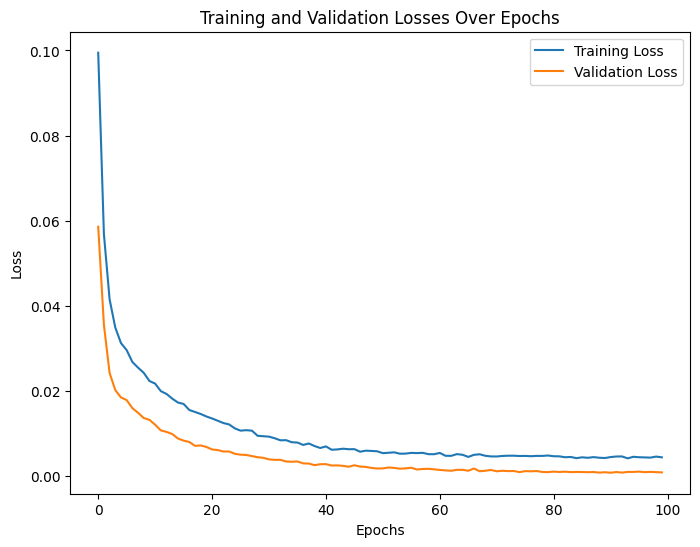

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(X_test)
predictions_reshaped = predictions.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)

actual_predictions = scaler_y.inverse_transform(predictions_reshaped)
actual_y_test = scaler_y.inverse_transform(y_test_reshaped)

mse = mean_squared_error(y_test, predictions)
scaled_back_mse = mean_squared_error(actual_y_test, actual_predictions)
print(f'Mean Squared Error: {mse}')
print(f'Scaled Back Mean Squared Error: {scaled_back_mse}')

31/31 [==============================] - 0s 5ms/step
Mean Squared Error: 0.0006070348117362751
Scaled Back Mean Squared Error: 6.051787100191435


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#Root Mean Square Error
rmse = np.sqrt(mean_squared_error(actual_y_test, actual_predictions))

#Mean Absolute Percentage Error
mape = np.mean(np.abs((actual_y_test - actual_predictions) / actual_y_test)) * 100

#R-squared (R2)
r2 = r2_score(actual_y_test, actual_predictions)

print("RMSE:", rmse)
print("MAPE:", mape)
print("R2 Score:", r2)

RMSE: 2.4600380282002625
MAPE: 2.1983799619406943
R2 Score: 0.9847083504138852


In [ ]:
mae = mean_absolute_error(y_test, predictions)
scaled_back_mae = mean_absolute_error(actual_y_test, actual_predictions)

print(f'Mean Absolute Error: {mae}')
print(f'Scaled Back Mean Absolute Error: {scaled_back_mae}')

Mean Absolute Error: 0.01976181755402235
Scaled Back Mean Absolute Error: 1.973158170556291


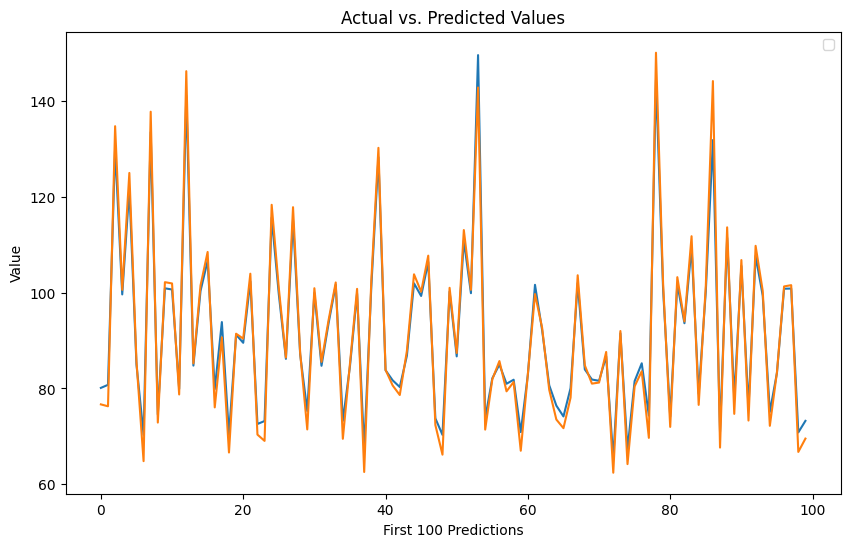

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(actual_predictions[:100]))
plt.plot(np.array(actual_y_test[:100]))
plt.title('Actual vs. Predicted Values')
plt.xlabel('First 100 Predictions')
plt.ylabel('Value')
plt.legend()
plt.grid(False)
plt.show()

#SVR

In [ ]:
#param Grid
param_grid = {
    'kernel': ['rbf','sigmoid'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1,0.5, 1.0]
}

svr_model = SVR()

#grid search initialization
grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

grid_search.fit(X_train.reshape(X_train.shape[0], -1), y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)

best_svr_model = grid_search.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Parameters: {'C': 1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
y_pred = best_svr_model.predict(X_test.reshape(X_test.shape[0], -1))


y_pred_reshaped = y_pred.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)

actual_pred = scaler_y.inverse_transform(y_pred_reshaped)
actual_Y_test = scaler_y.inverse_transform(y_test_reshaped)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
scaled_back_mse = mean_squared_error(actual_Y_test, actual_pred)
print(f'Mean Squared Error: {mse}')
print(f'Scaled Back Mean Squared Error: {scaled_back_mse}')

Mean Squared Error: 0.0011170180048311192
Scaled Back Mean Squared Error: 11.136025445637834


In [ ]:
rmse = np.sqrt(mean_squared_error(actual_Y_test, actual_pred))
print("Root Mean Squared Error:", rmse)

# Calculate R-squared
r2 = r2_score(actual_Y_test, actual_pred)
print("R-squared:", r2)

# Calculate MAPE
def mean_absolute_percentage_error(y_true, actual_pred):
    return np.mean(np.abs((y_true - actual_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(actual_Y_test, actual_pred)
print("Mean Absolute Percentage Error:", mape)

mse = mean_squared_error(actual_Y_test, actual_pred)
print("Scaled back Mean Squared Error:", mse)

Root Mean Squared Error: 3.337068390914072
R-squared: 0.9718615020526142
Mean Absolute Percentage Error: 2.6663464384047537
Scaled back Mean Squared Error: 11.136025445637834


In [ ]:
mae = mean_absolute_error(y_test, predictions)
scaled_back_mae = mean_absolute_error(actual_y_test, actual_predictions)

print(f'Mean Absolute Error: {mae}')
print(f'Scaled Back Mean Absolute Error: {scaled_back_mae}')

Mean Absolute Error: 0.01976181755402235
Scaled Back Mean Absolute Error: 1.933058853751037


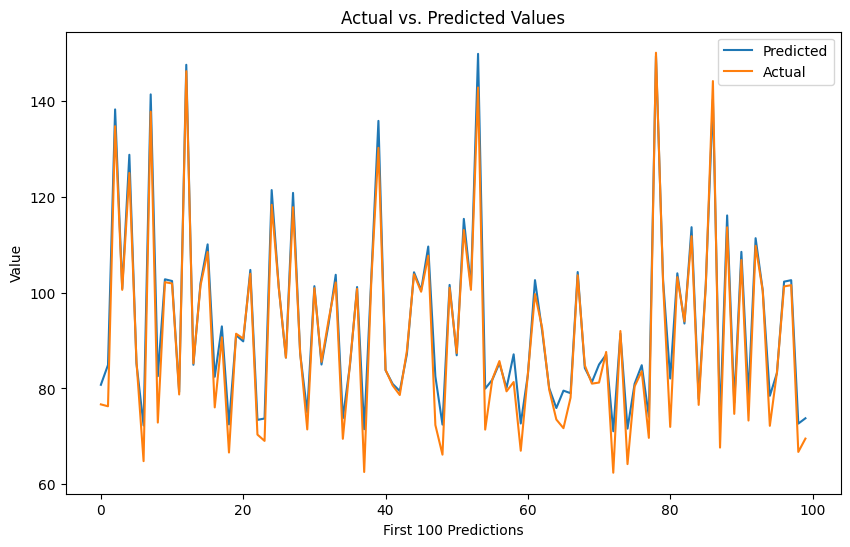

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(100), actual_pred[:100], label='Predicted')
plt.plot(range(100), actual_Y_test[:100], label='Actual')
plt.title('Actual vs. Predicted Values')
plt.xlabel('First 100 Predictions')
plt.ylabel('Value')
plt.legend()
plt.grid(False)
plt.show()

#Transformer

In [ ]:
def transformer_model(input_shape, head_size, num_heads, ff_dim, num_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_blocks):
        # Multi-head self-attention
        res = x
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x = layers.Dropout(dropout)(x)
        x = layers.Add()([res, x])

        # Feed Forward
        res = x
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.Dense(input_shape[-1])(x)
        x = layers.Dropout(dropout)(x)
        x = layers.Add()([res, x])

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)

    # MLP
    for units in mlp_units:
        x = layers.Dense(units, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

input_shape = (n_past, n_features)
head_size = 64
num_heads = 3
ff_dim = 32
num_blocks = 2
mlp_units = [128]
dropout = 0.2
mlp_dropout = 0.2


model = transformer_model(input_shape, head_size, num_heads, ff_dim, num_blocks, mlp_units, dropout=dropout, mlp_dropout=mlp_dropout)

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss="mean_squared_error", optimizer=optimizer)

history = model.fit(X_train, y_train, validation_split=0.2, batch_size=64, epochs=150, verbose=1)
model.summary()
y_pred = model.predict(X_test)
mse = np.mean((y_test - y_pred)**2)
print("Mean Squared Error (MSE):", mse)

r_squared = r2_score(y_test, y_pred)
print("R-squared:", r_squared)

Epoch 1/150
49/49 [==============================] - 8s 41ms/step - loss: 0.0432 - val_loss: 0.0023
Epoch 2/150
49/49 [==============================] - 1s 22ms/step - loss: 0.0097 - val_loss: 0.0027
Epoch 3/150
49/49 [==============================] - 1s 22ms/step - loss: 0.0065 - val_loss: 0.0030
Epoch 4/150
49/49 [==============================] - 1s 20ms/step - loss: 0.0054 - val_loss: 0.0019
Epoch 5/150
49/49 [==============================] - 1s 22ms/step - loss: 0.0049 - val_loss: 0.0015
Epoch 6/150
49/49 [==============================] - 1s 22ms/step - loss: 0.0041 - val_loss: 0.0012
Epoch 7/150
49/49 [==============================] - 1s 22ms/step - loss: 0.0037 - val_loss: 9.8065e-04
Epoch 8/150
49/49 [==============================] - 1s 22ms/step - loss: 0.0035 - val_loss: 0.0012
Epoch 9/150
49/49 [==============================] - 1s 22ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 10/150
49/49 [==============================] - 1s 22ms/step - loss: 0.0028 - val_loss: 8.

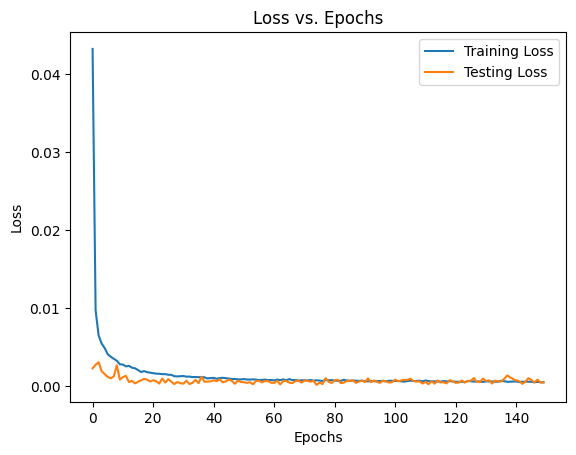

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.show()

In [ ]:
predictions_reshaped = y_pred.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)
actual_predictions = scaler_y.inverse_transform(predictions_reshaped)
actual_y_test = scaler_y.inverse_transform(y_test_reshaped)

In [ ]:
mse = mean_squared_error(y_test, predictions)
scaled_back_mse = mean_squared_error(actual_y_test, actual_predictions)
print(f'Mean Squared Error: {mse}')
print(f'Scaled Back Mean Squared Error: {scaled_back_mse}')

Mean Squared Error: 0.0006070348117362751
Scaled Back Mean Squared Error: 5.1134254628769495


In [ ]:
mae = mean_absolute_error(y_test, predictions)
scaled_back_mae = mean_absolute_error(actual_y_test, actual_predictions)

print(f'Mean Absolute Error: {mae}')
print(f'Scaled Back Mean Absolute Error: {scaled_back_mae}')

Mean Absolute Error: 0.01976181755402235
Scaled Back Mean Absolute Error: 1.933058853751037


In [ ]:
#RMSE (Root Mean Square Error)
rmse = np.sqrt(mean_squared_error(actual_y_test, actual_predictions))

#MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((actual_y_test - actual_predictions) / actual_y_test)) * 100

#R-squared (R2)
r2 = r2_score(actual_y_test, actual_predictions)

print("RMSE:", rmse)
print("MAPE:", mape)
print("R2 Score:", r2)

RMSE: 2.261288451939944
MAPE: 2.0883494757610785
R2 Score: 0.9870794016596258


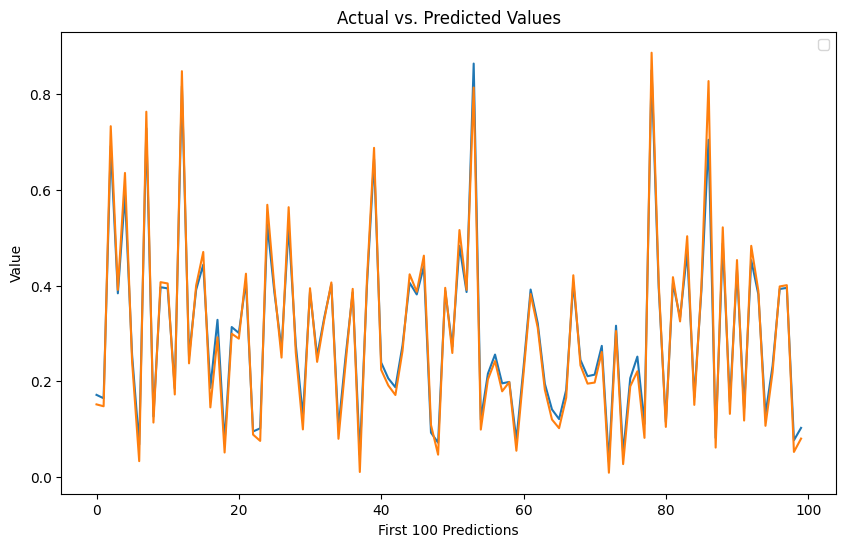

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(y_pred[:100]))
plt.plot(np.array(y_test[:100]))
plt.title('Actual vs. Predicted Values')
plt.xlabel('First 100 Predictions')
plt.ylabel('Value')
plt.legend()
plt.grid(False)
plt.show()